# Clustering combined with Hough line detection

This ipython notebook contains the combined code from Junjie and myself for Day 1, and it shows a preliminary result.

In [1]:
# import necessary libraries 
from sklearn.cluster import KMeans
import joblib
import os
import numpy as np
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
# A class Junjie wrote for doing the Kmeans clustering
# It saves the results for color clustered image and filterd image with only yellow left 
class KMeans_Cached:

    def __init__(self, K, filename):
        self.joblib_file = "Cached_Models/"+filename.split('/')[-1].split('.')[0]+"_"+str(K)+".pkl"

        self.K = K
        self.img = cv2.imread(filename)
        self.img_data = np.array(self.img)
        self.n = self.img_data.shape[0]
        if os.path.isfile(self.joblib_file):
            self.model = joblib.load(self.joblib_file)
            self.model_exists=True
        else:
            self.model = KMeans(n_clusters=K)
            self.model_exists=False

    def fit(self):
        if not self.model_exists:
            pixels = self.img_data.reshape((-1, 3))
            self.model.fit(pixels)

            os.makedirs(os.path.dirname(self.joblib_file), exist_ok=True)
            joblib.dump(self.model, self.joblib_file)
            self.model_exists=True

    def output_image(self):
        labels=self.model.labels_
        values=self.model.cluster_centers_.squeeze()

        output_name = "Output/"+self.joblib_file.split('/')[-1].split('.')[0]+".jpg"
        os.makedirs(os.path.dirname(output_name), exist_ok=True)
        cv2.imwrite(output_name, values[labels].reshape((self.n,self.n,3)))

    def output_mask(self, color):
        labels=self.model.labels_

        color_label = self.model.predict(color.reshape((1, -1)))
        mask = (labels==color_label).reshape((self.n,self.n,1))

        output_name = "Output/"+self.joblib_file.split('/')[-1].split('.')[0]+"mask.jpg"
        os.makedirs(os.path.dirname(output_name), exist_ok=True)
        cv2.imwrite(output_name, self.img_data*mask)

A class Junjie wrote to pick the yellow color according to the Lot3 image.

In [3]:
class Yellow_Color:

    def __init__(self):

        img = cv2.imread("Parking Lot/Lot3.tif")
        img_data = np.array(img)

        b = np.mean(img_data[205:215, 600:1000, 0])
        g = np.mean(img_data[205:215, 600:1000, 1])
        r = np.mean(img_data[205:215, 600:1000, 2])
        self.bgr = np.array([b,g,r])


In [4]:
y = Yellow_Color();

Althernatively, we can also use a pre-defined yellow color in BGR channel shown in the next cell. 

In [5]:
# y.bgr = np.array([0, 210, 200])

In [6]:
# loading the image we are interested in and do a 5 groups clustering
filename = "Parking Lot/Lot1.tif"

K = 5
kmc = KMeans_Cached(K, filename)
kmc.fit()
kmc.output_image()
kmc.output_mask(y.bgr)

### After getting the masked image, now we can do some image processing

In [7]:
# opencv read as BGR, instead of RGB. So convert
img = cv2.imread(filename, 1)
RGBimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

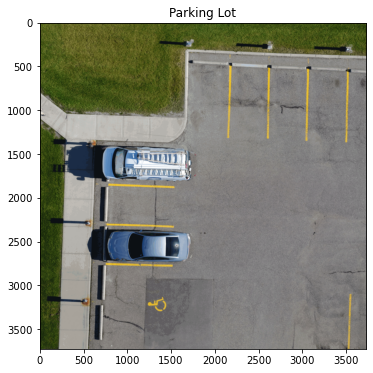

Our image has the shape: (3724, 3724, 3)


In [8]:
# plot the parking lot image
plt.figure(figsize=(6,6))
plt.imshow(RGBimg)
plt.title('Parking Lot');
plt.show()
print("Our image has the shape: {}".format(RGBimg.shape))

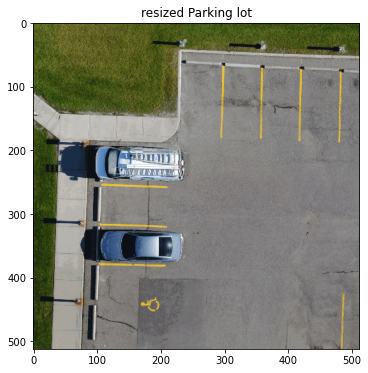

In [9]:
# orignal parking lot image is too big, let's resize it
plt.figure(figsize=(6,6))
img_resized = cv2.resize(RGBimg, (512,512))
plt.imshow(img_resized)
plt.title('resized Parking lot');
plt.show()

In [10]:
# Input the image with mask 
masked_filename = "Output/"+ filename.split('/')[-1].split('.')[0]+"_"+str(K)+"mask.jpg"
masked_img = cv2.imread(masked_filename, 1)
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)

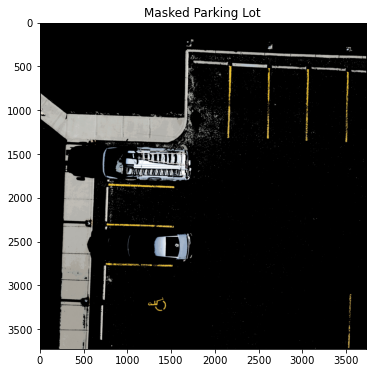

Our image has the shape: (3724, 3724, 3)


In [11]:
# plot the marsked parking lot image
plt.figure(figsize=(6,6))
plt.imshow(masked_img)
plt.title('Masked Parking Lot');
plt.show()
print("Our image has the shape: {}".format(RGBimg.shape))


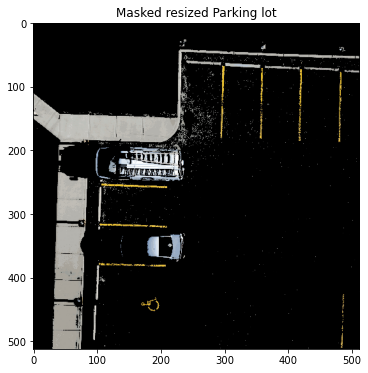

True

In [12]:
# let's resize it
plt.figure(figsize=(6,6))
masked_img_resized = cv2.resize(masked_img, (512,512))
plt.imshow(masked_img_resized)
plt.title('Masked resized Parking lot');
plt.show()
cv2.imwrite('masked_small.jpg', cv2.cvtColor(masked_img_resized, cv2.COLOR_RGB2BGR))

### Let's now apply Gaussian filter to the mask image

In [13]:
# apply Gaussin filter to the masked image
gblur = cv2.GaussianBlur(masked_img_resized, (5,5),0)

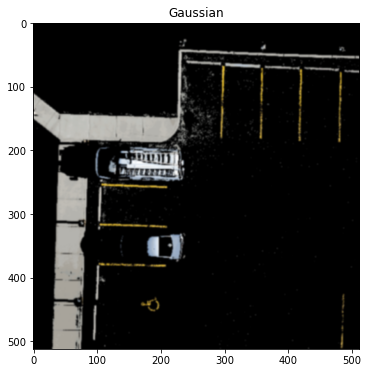

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(gblur)
plt.title('Gaussian');
plt.show()

### Canny Edge Detection

Minval and maxval are two values should play around with. The value I used here is just a random guess.

In [15]:
# apply canny edge detection
minval = 150
maxval = 250
canny_bF = cv2.Canny(gblur, minval, maxval)

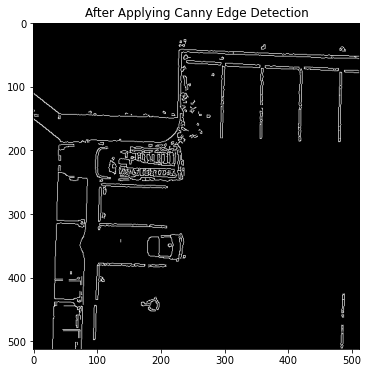

True

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(canny_bF, cmap = 'gray')
plt.title('After Applying Canny Edge Detection');
plt.show()
cv2.imwrite('edge_small.jpg', canny_bF)

### Hough Transform Line Detection

Threshold, minLineLength, maxLineGap are three parameters need to be played around with. Here is just a random guess.

In [17]:
# doing the probabilistic Hough Transform line detection
lines = cv2.HoughLinesP(canny_bF, 1, np.pi/180, threshold = 10, minLineLength = 10, maxLineGap = 10)
img_resized = cv2.resize(RGBimg, (512,512))

In [18]:
# draw the detected lines
for line in lines:
    x1, y1, x2, y2 = line[0]   
    cv2.line(img_resized, (x1,y1), (x2, y2), ( 255,0, 0), 2)

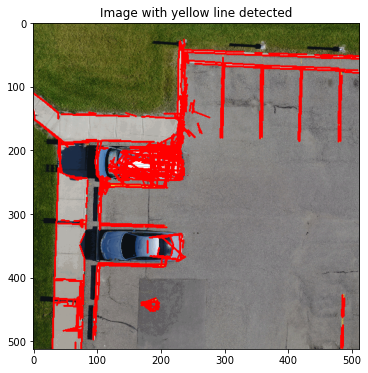

True

In [19]:
plt.figure(figsize=(6,6))
plt.imshow(img_resized)
plt.title('Image with yellow line detected');
plt.show()
cv2.imwrite('lined_small.jpg', cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))

There too many random lines in the deteced image. We probably should use a bigger k number in clustering,